<a href="https://colab.research.google.com/github/marianoraholin/project_CABA/blob/main/project_CABA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este proyecto se centra en el análisis de los datos de alojamientos en Airbnb en Ciudad de Buenos Aires, con el objetivo de identificar patrones y tendencias clave que influyen en la dinámica del mercado. La investigación se centra en análisis geoespaciales y se incorporan datos espaciales adicionales, como los radios censales de Buenos Aires, para enriquecer el análisis y realizar una comparación en una escala uniforme.


In [ ]:
! pip install folium
! pip install mapclassify
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
url = "https://github.com/pabanib/dataframes/raw/master/airbnb/caba_airbnb.csv"
nombre_archivo = "caba_airbnb.csv"
try:
    respuesta = requests.get(url)
    if respuesta.status_code == 200:
        with open(nombre_archivo, "wb") as archivo:
            archivo.write(respuesta.content)
        print("Archivo descargado exitosamente como:", nombre_archivo)
    else:
        print("Error al descargar el archivo. Código de respuesta:", respuesta.status_code)
except requests.RequestException as e:
    print("Error durante la solicitud HTTP:", e)

Archivo descargado exitosamente como: caba_airbnb.csv


In [ ]:
url1 = "https://github.com/pabanib/dataframes/raw/master/censo/caba_dptos.zip"
try:
    respuesta1 = requests.get(url1, stream=True)
    respuesta1.raise_for_status()
    with open("caba_dptos.zip", "wb") as archivo_zip1:
        for chunk in respuesta1.iter_content(chunk_size=8192):
            archivo_zip1.write(chunk)
    with zipfile.ZipFile("caba_dptos.zip", 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Archivo ZIP 1 descomprimido correctamente.")
except requests.exceptions.RequestException as e:
    print("Error al descargar o descomprimir el archivo ZIP 1:", e)


Archivo ZIP 1 descomprimido correctamente.


In [ ]:
url2 = "https://github.com/pabanib/dataframes/raw/master/censo/radios_caba.zip"
try:
    respuesta2 = requests.get(url2, stream=True)
    respuesta2.raise_for_status()
    with open("radios_caba.zip", "wb") as archivo_zip2:
        for chunk in respuesta2.iter_content(chunk_size=8192):
            archivo_zip2.write(chunk)
    with zipfile.ZipFile("radios_caba.zip", 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Archivo ZIP 2 descomprimido correctamente.")
except requests.exceptions.RequestException as e:
    print("Error al descargar o descomprimir el archivo ZIP 2:", e)


Archivo ZIP 2 descomprimido correctamente.


El primer archivo contiene los datos de Airbnb en la Ciudad de Buenos Aires. Como primer paso vas a realizar una limpieza de los datos, eliminando las columnas que no vamos a utilizar para el análisis y transformando la variable de precios a un tipo de dato numérico. Posteriormente filtramos los outliers y utilizamos la longitud y latitud para crear un geodataframe


In [ ]:
caba_airbnb = pd.read_csv("caba_airbnb.csv")

In [ ]:
caba_airbnb.head()

latitude  longitude  bathrooms    bathrooms_text  bedrooms  beds  \
0 -34.57896  -58.43448        NaN            1 bath       1.0   1.0   
1 -34.60728  -58.41949        NaN  1.5 shared baths       1.0   1.0   
2 -34.59495  -58.40440        NaN            1 bath       1.0   1.0   
3 -34.57943  -58.48487        NaN           2 baths       1.0   2.0   
4 -34.59234  -58.39956        NaN            1 bath       1.0   1.0   

        price  minimum_nights  maximum_nights  minimum_minimum_nights  ...  \
0  $10,401.00               7              90                       7  ...   
1   $2,692.00               3           10000                       3  ...   
2  $13,522.00               5             180                       5  ...   
3   $9,318.00               1            1125                       1  ...   
4   $9,465.00              14            1125                      14  ...   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         5.00                    5.00                 4.56   
1                         4.82                    4.61                 4.71   
2                         4.96                    4.75                 4.78   
3                         4.50                    4.50                 5.00   
4                         4.95                    4.90                 4.40   

   license  instant_bookable  calculated_host_listings_count  \
0      NaN                 f                               1   
1      NaN                 f                               2   
2      NaN                 f                              24   
3      NaN                 f                               2   
4      NaN                 f                              30   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   
2                                          24   
3                                           0   
4                                          29   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             2   
2                                             0   
3                                             2   
4                                             0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.06  
1                                            0               0.29  
2                                            0               0.89  
3                                            0               0.03  
4                                            0               0.19  

[5 rows x 41 columns]

In [ ]:
caba_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22713 entries, 0 to 22712
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      22713 non-null  float64
 1   longitude                                     22713 non-null  float64
 2   bathrooms                                     0 non-null      float64
 3   bathrooms_text                                22688 non-null  object 
 4   bedrooms                                      19655 non-null  float64
 5   beds                                          22481 non-null  float64
 6   price                                         22713 non-null  object 
 7   minimum_nights                                22713 non-null  int64  
 8   maximum_nights                                22713 non-null  int64  
 9   minimum_minimum_nights                        22713 non-null 

In [ ]:
print(caba_airbnb.columns)

Index(['latitude', 'longitude', 'bathrooms', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listi

In [ ]:
caba_airbnb = caba_airbnb.drop(columns=[ 'bathrooms_text','minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'])

In [ ]:
def price_to_float(x):
    x = x.replace('$','').replace(',','')
    return float(x)

In [ ]:
caba_airbnb.price = caba_airbnb.price.apply(price_to_float)

In [ ]:
Q1 = caba_airbnb['price'].quantile(0.25)
Q3 = caba_airbnb['price'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

In [ ]:
def filter_price_by_limits(df, lower_limit, upper_limit):
    return df[(df['price'] >= lower_limit) & (df['price'] <= upper_limit)]

caba_airbnb= filter_price_by_limits(caba_airbnb, lower_limit, upper_limit)

In [ ]:
geo = gpd.points_from_xy(caba_airbnb.longitude, caba_airbnb.latitude)
caba_airbnb = gpd.GeoDataFrame(caba_airbnb, geometry=geo)

In [ ]:
caba_airbnb.crs = "WGS 84"

Cargamos los otros dos archivos, que contienen datos espaciales de la Ciudad de Buenos Aires y sus radios censales. Transformamos los 3 dataframe para que todos se encuentren en la misma escala

In [ ]:
caba = gpd.read_file("caba_dptos.shp")

In [ ]:
radios = gpd.read_file("radios_caba.shp")

In [ ]:
caba_airbnb = caba_airbnb.to_crs(epsg = 4326)
caba = caba.to_crs(epsg = 4326)
radios = radios.to_crs(epsg = 4326)

El primer gráfico se representan en rojo todos los alquilere presentes en Airbnb en la ciudad de Buenos Aires



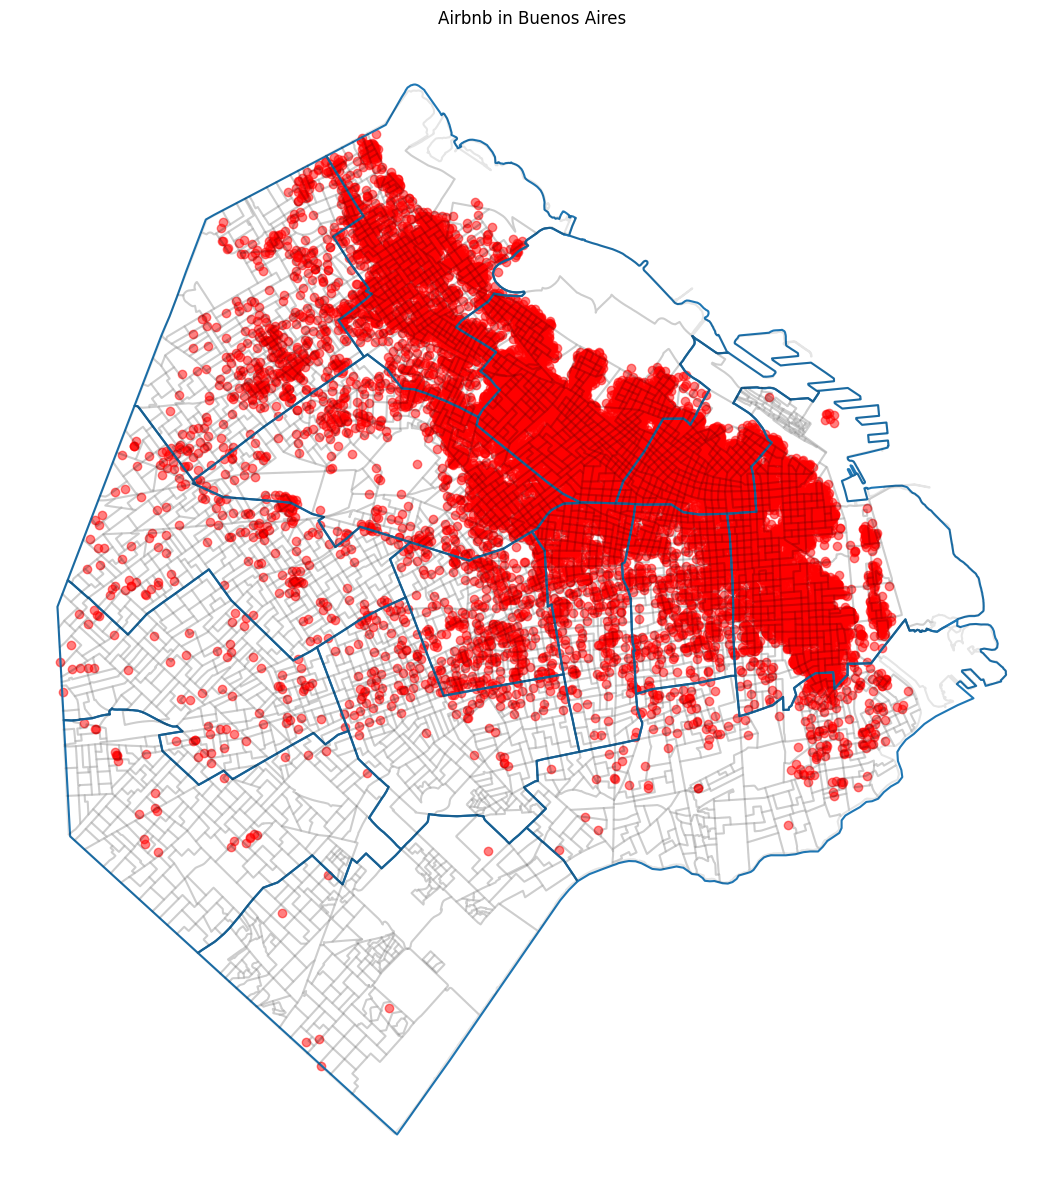

In [ ]:
base = caba.boundary.plot(figsize = (15,15))
radios.boundary.plot(ax = base, color = 'black', alpha = 0.1)
caba_airbnb.plot(ax = base, color = 'red', alpha = 0.5)
plt.title('Airbnb in Buenos Aires')
base.set_axis_off()

Para el próximo gráfico filtramos solo aquellos departamentos que hayan recibido el puntaje más alto en ubicación y que cuenten con un mínimo de 5 reviews

In [ ]:
airbnb_review = caba_airbnb[(caba_airbnb['number_of_reviews'] > 5) & (caba_airbnb['review_scores_location'] >= 5)]

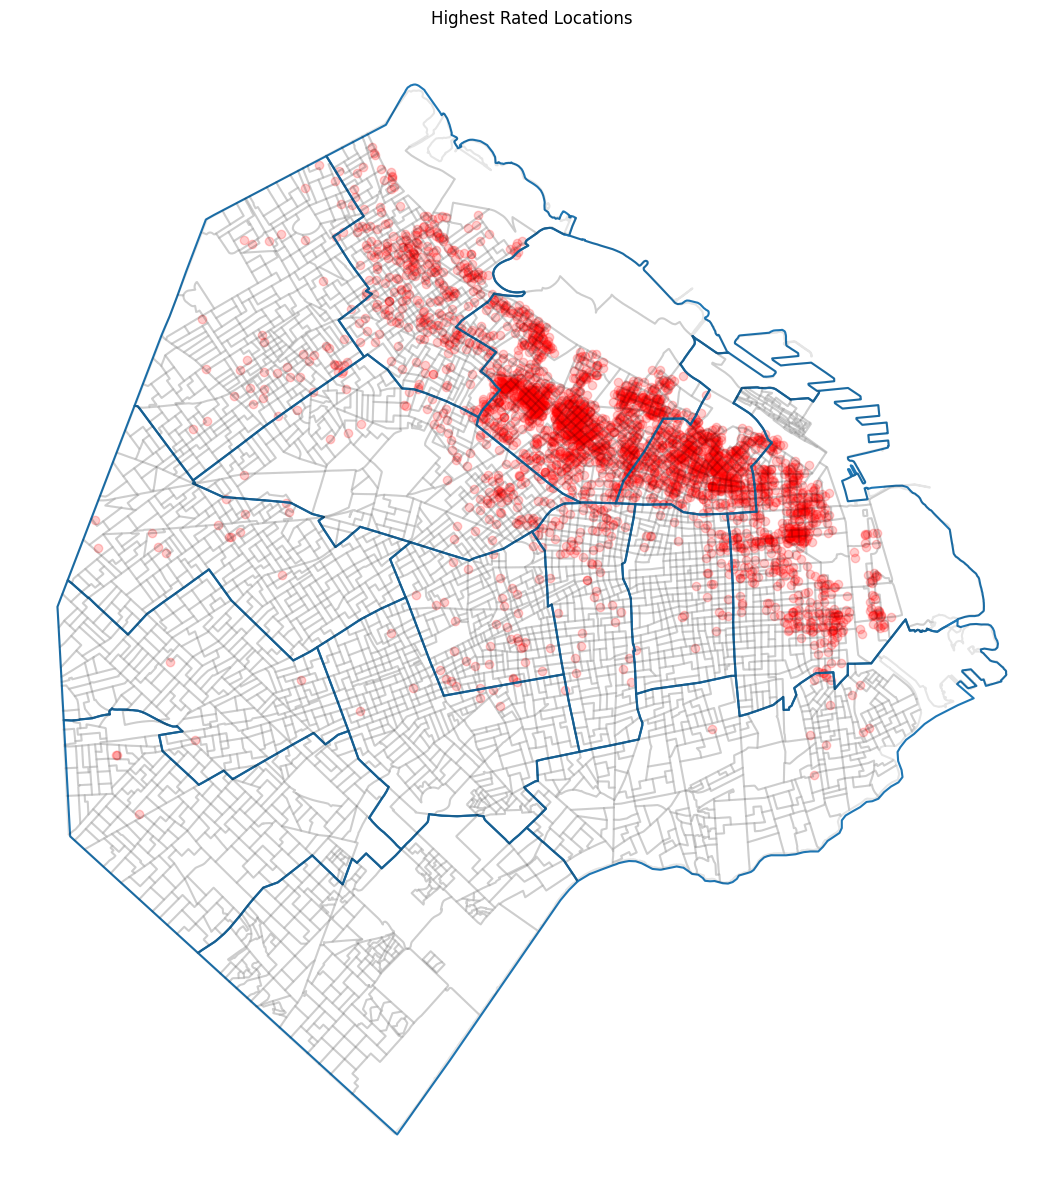

In [ ]:
base = caba.boundary.plot(figsize = (15,15))
radios.boundary.plot(ax = base, color = 'black', alpha = 0.1)
airbnb_review.plot(ax = base, color = 'red', alpha = 0.2)
plt.title('Highest Rated Locations')
base.set_axis_off()

Para el siguiente gráfico redondeamos el precio promedio de los alquileres y dividimos, en verde, los entre aquellos que se encuentran por debajo, y en rojo, los que se encuentran por encima. Podemos ver a simple vista como coinciden los alquileres caros con las ubicaciones mejor valoradas en el gráfico anterior

In [ ]:
caba_airbnb.price.mean()

9527.71480489671

In [ ]:
low_price = caba_airbnb[(caba_airbnb['price'] < 10000)]
high_price = caba_airbnb[(caba_airbnb['price'] > 10000)]

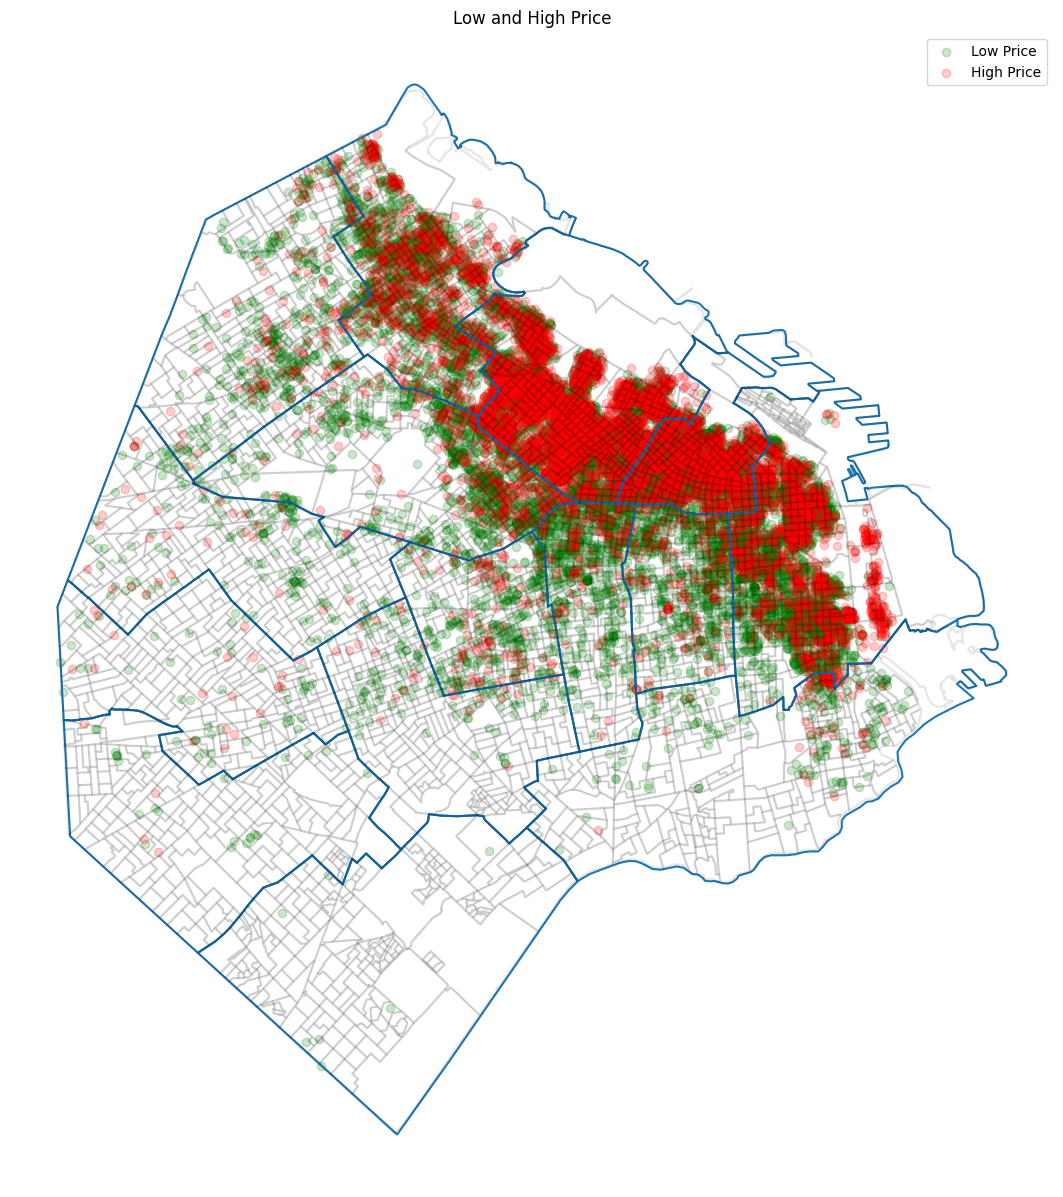

In [ ]:
base = caba.boundary.plot(figsize = (15,15))
radios.boundary.plot(ax = base, color = 'black', alpha = 0.1)
low_price.plot(ax = base, color = 'green', alpha = 0.2, label='Low Price')
high_price.plot(ax = base, color = 'red', alpha = 0.2, label='High Price')
plt.title('Low and High Price')
base.set_axis_off()
plt.legend(loc='upper right')

Realizamos una unión entre el el dataframe de Airbnb con el de los radios censales. Después realizamos un agrupamiento por los radios censales para calcular el promedio de precio en cada uno de ellos. En el gráfico siguiente podemos ver un mapa de calor del precio promedio en cada radio censal



In [ ]:
airbnb_radio = radios.sjoin( caba_airbnb, how = 'inner', predicate = 'contains')


In [ ]:
caba_radio = airbnb_radio.dissolve(by = 'link', aggfunc = { 'area': 'first',
                                                            'perimeter': 'first',
                                                            'depto': 'first',
                                                            'price': 'mean',
                                                            'id': 'count',
                                                            'number_of_reviews': 'mean'
                                                            })

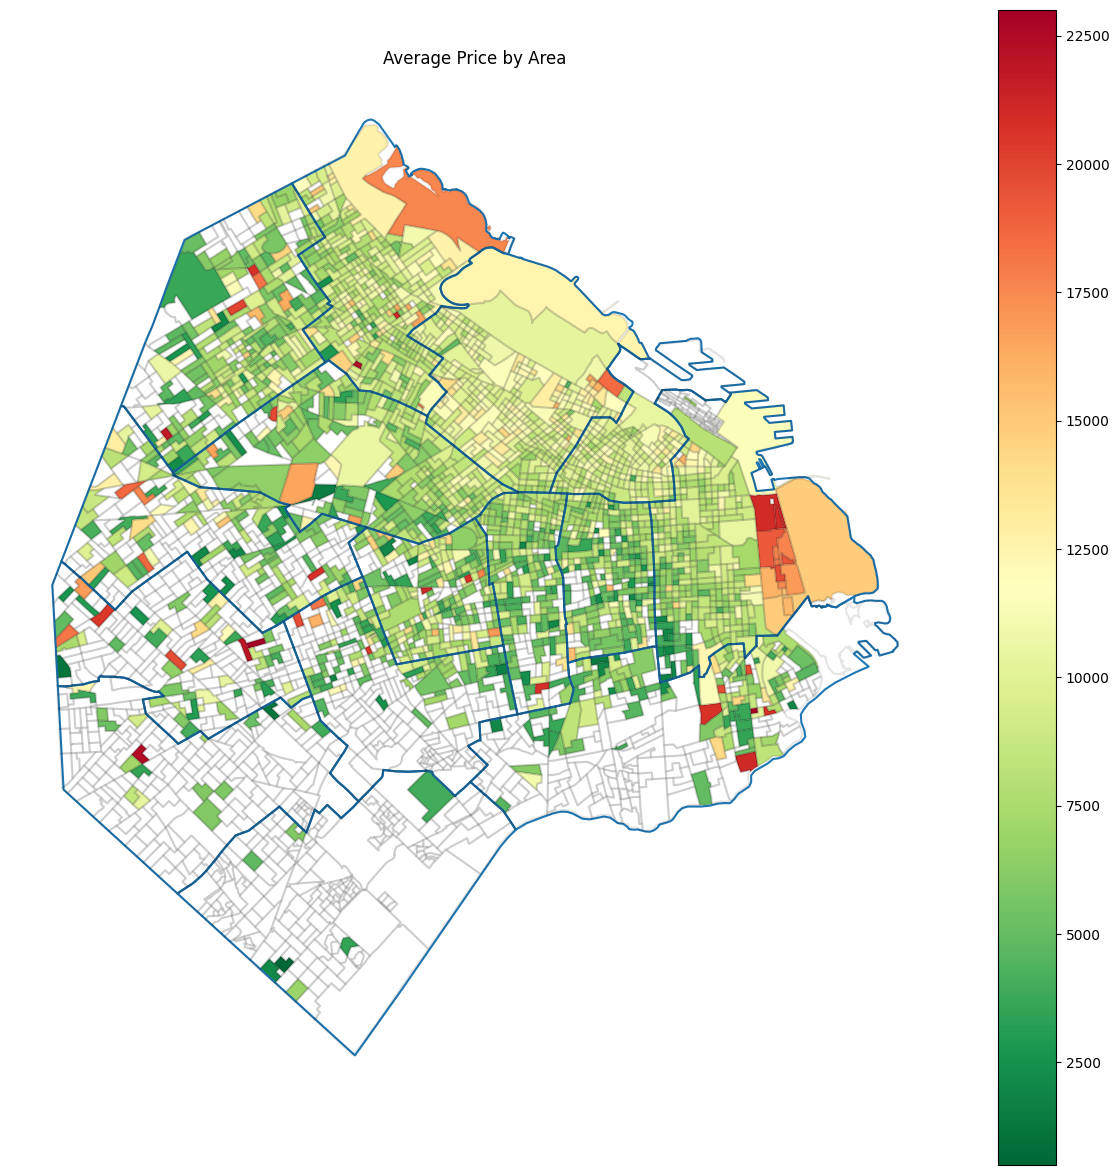

In [ ]:
base = caba.boundary.plot(figsize = (15,15))
radios.boundary.plot(ax = base, color = 'black', alpha = 0.1)
plt.title('Average Price by Area')
caba_radio.plot('price', ax = base, legend = True, alpha = 1, cmap='RdYlGn_r')
base.set_axis_off()

Para el último gráfico aplicamos nuevamente un filtro entre caros y baratos, esta vez aplicado a el precio promedio por radio censales. Nos permite ver que existen radios censales baratos dentro de comunas que son consideradas caras

In [ ]:
radio_low_price = caba_radio[(caba_radio['price'] < 10000)]
radio_high_price = caba_radio[(caba_radio['price'] > 10000)]

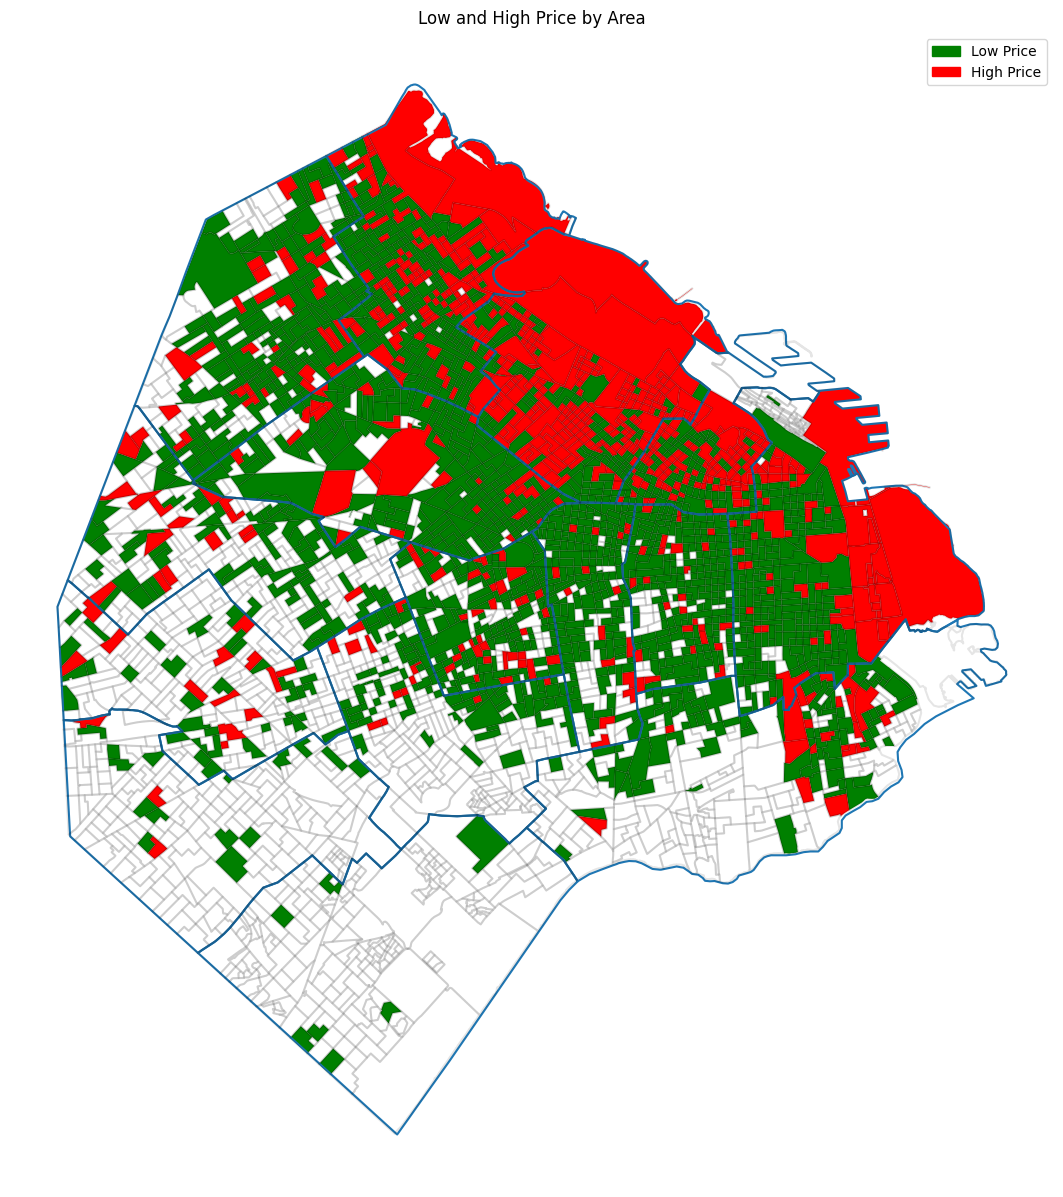

In [ ]:
base = caba.boundary.plot(figsize = (15,15))
radios.boundary.plot(ax = base, color = 'black', alpha = 0.1)
radio_low_price.plot(ax = base, color = 'green', alpha = 1)
radio_high_price.plot(ax = base, color = 'red', alpha = 1)
plt.title('Low and High Price by Area')
base.set_axis_off()

import matplotlib.patches as mpatches
low_price_patch = mpatches.Patch(color='green', label='Low Price')
high_price_patch = mpatches.Patch(color='red', label='High Price')
plt.legend(handles=[low_price_patch, high_price_patch], loc='upper right')